In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [3]:
label = []
path = []
for dir_name, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':              
            if dir_name.split()[-1]!='GT':                       
                label.append(os.path.split(dir_name)[-1])         
                path.append(os.path.join(dir_name,filename))     

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [4]:
df['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

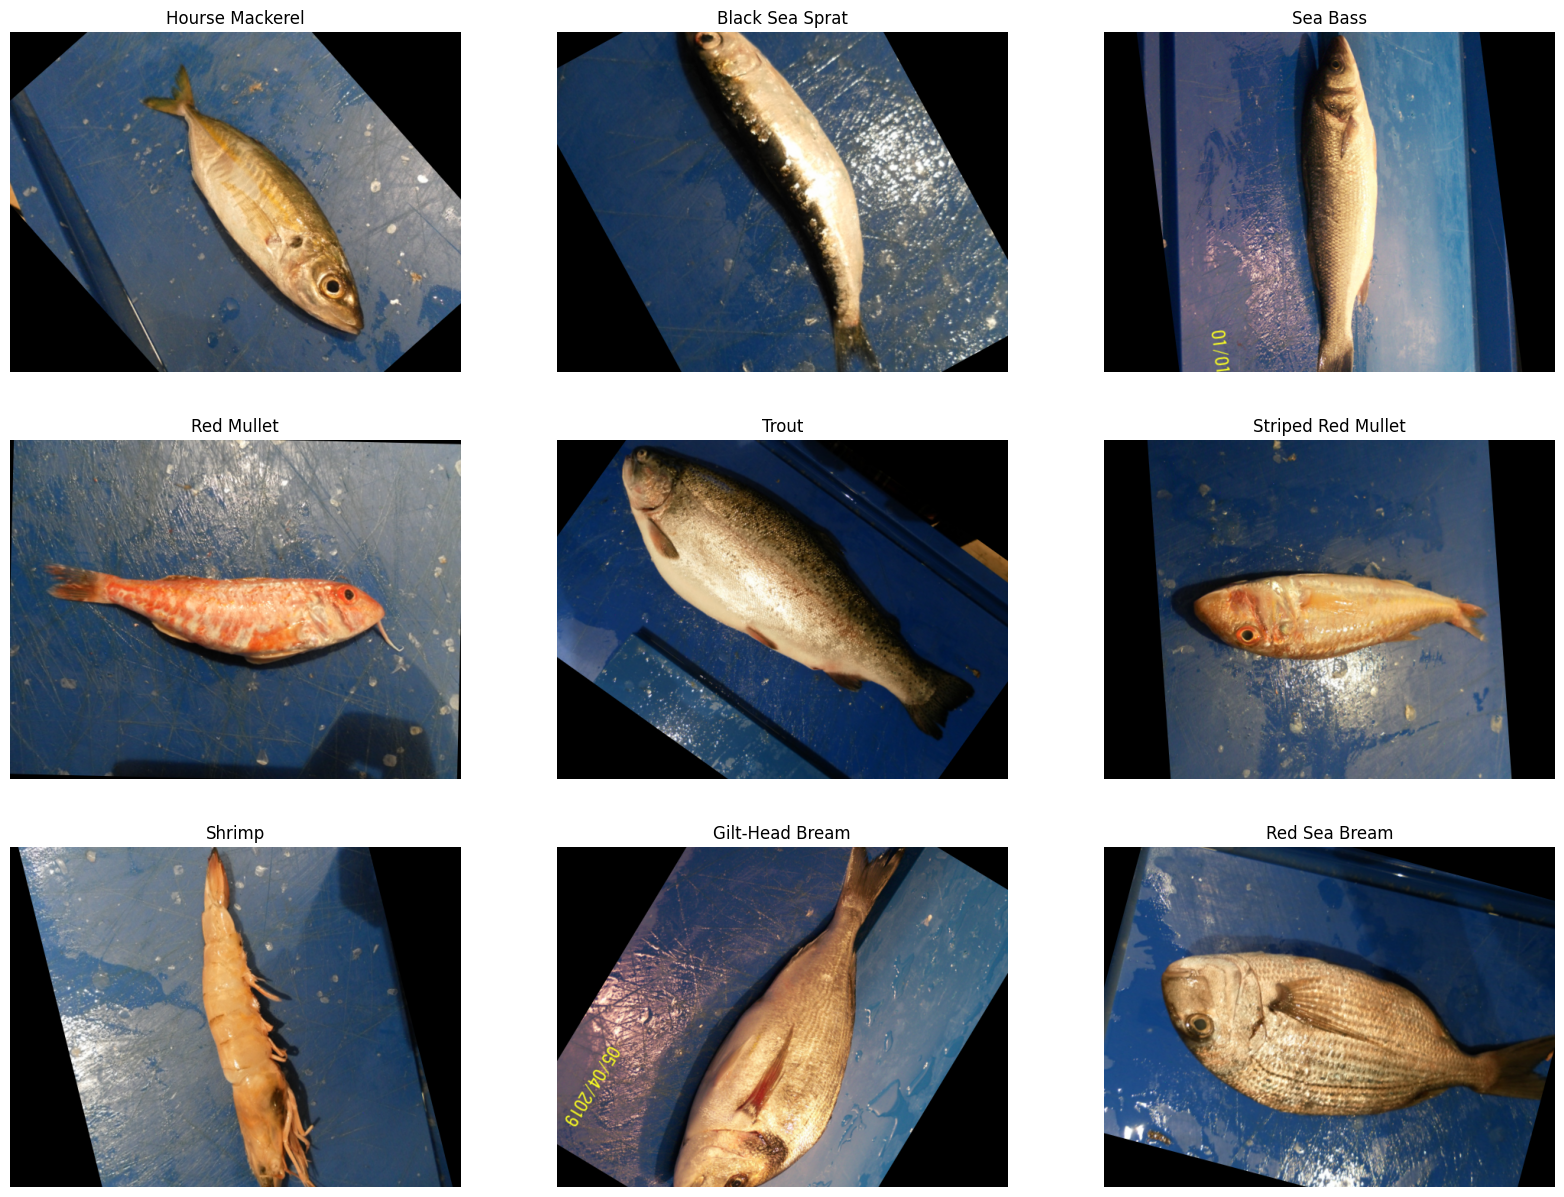

In [5]:
idx = 0
plt.figure(figsize=(20,15))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [6]:
main_directory = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
images = []
labels = []
for directory in tqdm(os.listdir(main_directory)):
    next_directory = f"{main_directory}/{directory}"
    if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
    i = 0
    for images_directory in os.listdir(next_directory):
        if "GT" not in images_directory:
            final_directory = f"{next_directory}/{images_directory}"
            for image in os.listdir(final_directory):
                images.append(cv2.resize(cv2.imread(f"{final_directory}/{image}"),(256, 256)).astype('float32') / 255)
                labels.append(images_directory)
        i+=1

100%|██████████| 12/12 [02:11<00:00, 10.93s/it]


In [7]:
print(images[0])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, random_state=0, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=0, test_size = 0.5)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [10]:
print(type(X_train))
print(X_train[0].shape)
print(X_val[0].shape)
print(X_test[0].shape)
len(X_train)

<class 'list'>
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6300

In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
print(y_train)

['Sea Bass' 'Black Sea Sprat' 'Red Mullet' ... 'Trout' 'Red Mullet'
 'Sea Bass']


In [13]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [14]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
model = tf.keras.models.Sequential([
   
  tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
results = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=70,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True
                        )
                    ],
                    validation_data=(X_val, y_val))

Epoch 1/70


I0000 00:00:1729800329.379971     102 service.cc:145] XLA service 0x7eb910003360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729800329.380780     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.0959 - loss: 7.0096

I0000 00:00:1729800333.302585     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - accuracy: 0.1132 - loss: 7.5043 - val_accuracy: 0.1111 - val_loss: 2.1972
Epoch 2/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1407 - loss: 2.7840 - val_accuracy: 0.1230 - val_loss: 2.1953
Epoch 3/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1710 - loss: 2.2368 - val_accuracy: 0.3274 - val_loss: 1.8487
Epoch 4/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.3243 - loss: 1.8453 - val_accuracy: 0.4941 - val_loss: 1.5863
Epoch 5/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4083 - loss: 1.6694 - val_accuracy: 0.5356 - val_loss: 1.4680
Epoch 6/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4144 - loss: 1.6506 - val_accuracy: 0.5630 - val_loss: 1.3145
Epoch 7/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.4610 - loss: 1.5282 - val_accuracy: 0.6526 - val_loss: 1.1903
Epoch 8/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.4988 - loss: 1.4329 - val_accuracy: 0.6593 - val

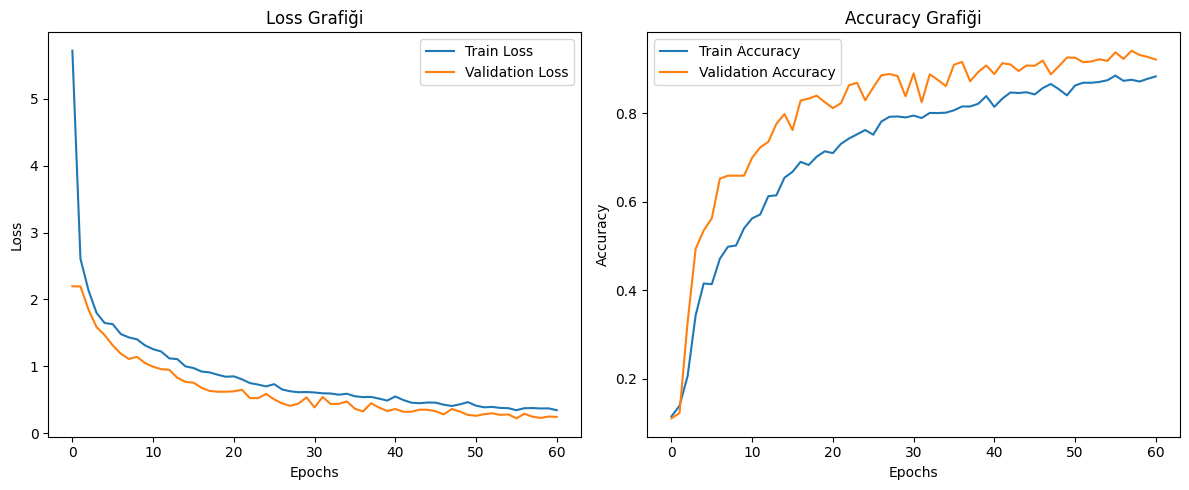

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.2628815472126007
Test Accuracy: 0.9229629635810852


In [21]:
test_labels = encoder.inverse_transform(y_test)
prediction_labels = encoder.inverse_transform(y_pred)

In [22]:
print(classification_report(test_labels, prediction_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      0.95      0.96       149
   Gilt-Head Bream       0.85      0.91      0.88       148
   Hourse Mackerel       0.91      0.96      0.93       155
        Red Mullet       0.99      0.98      0.98       144
     Red Sea Bream       0.94      0.95      0.95       167
          Sea Bass       0.91      0.93      0.92       148
            Shrimp       0.98      0.93      0.95       136
Striped Red Mullet       0.92      0.87      0.89       156
             Trout       0.84      0.83      0.84       147

          accuracy                           0.92      1350
         macro avg       0.92      0.92      0.92      1350
      weighted avg       0.92      0.92      0.92      1350

